In [1]:
import os

os.chdir("/home/hamza-arain/Documents/code/HumanActiityTrack")

In [2]:
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
import pandas as pd
import numpy as np
import copy


class ClassificationAlgorithms:

    # Forward selection for classification which selects a pre-defined number of features (max_features)
    # that show the best accuracy. We assume a decision tree learning for this purpose, but
    # this can easily be changed. It return the best features.
    def forward_selection(self, max_features, X_train, y_train):
        # Start with no features.
        ordered_features = []
        ordered_scores = []
        selected_features = []
        ca = ClassificationAlgorithms()
        prev_best_perf = 0

        # Select the appropriate number of features.
        for i in range(0, max_features):
            print(i)

            # Determine the features left to select.
            features_left = list(set(X_train.columns) - set(selected_features))
            best_perf = 0
            best_attribute = ""

            # For all features we can still select...
            for f in features_left:
                temp_selected_features = copy.deepcopy(selected_features)
                temp_selected_features.append(f)

                # Determine the accuracy of a decision tree learner if we were to add
                # the feature.
                (
                    pred_y_train,
                    pred_y_test,
                    prob_training_y,
                    prob_test_y,
                ) = ca.decision_tree(
                    X_train[temp_selected_features],
                    y_train,
                    X_train[temp_selected_features],
                )
                perf = accuracy_score(y_train, pred_y_train)

                # If the performance is better than what we have seen so far (we aim for high accuracy)
                # we set the current feature to the best feature and the same for the best performance.
                if perf > best_perf:
                    best_perf = perf
                    best_feature = f
            # We select the feature with the best performance.
            selected_features.append(best_feature)
            prev_best_perf = best_perf
            ordered_features.append(best_feature)
            ordered_scores.append(best_perf)
        return selected_features, ordered_features, ordered_scores

    # Apply a neural network for classification upon the training data (with the specified composition of
    # hidden layers and number of iterations), and use the created network to predict the outcome for both the
    # test and training set. It returns the categorical predictions for the training and test set as well as the
    # probabilities associated with each class, each class being represented as a column in the data frame.
    def feedforward_neural_network(
        self,
        train_X,
        train_y,
        test_X,
        hidden_layer_sizes=(100,),
        max_iter=2000,
        activation="logistic",
        alpha=0.0001,
        learning_rate="adaptive",
        gridsearch=True,
        print_model_details=False,
    ):

        if gridsearch:
            tuned_parameters = [
                {
                    "hidden_layer_sizes": [
                        (5,),
                        (10,),
                        (25,),
                        (100,),
                        (
                            100,
                            5,
                        ),
                        (
                            100,
                            10,
                        ),
                    ],
                    "activation": [activation],
                    "learning_rate": [learning_rate],
                    "max_iter": [1000, 2000],
                    "alpha": [alpha],
                }
            ]
            nn = GridSearchCV(
                MLPClassifier(), tuned_parameters, cv=5, scoring="accuracy"
            )
        else:
            # Create the model
            nn = MLPClassifier(
                hidden_layer_sizes=hidden_layer_sizes,
                activation=activation,
                max_iter=max_iter,
                learning_rate=learning_rate,
                alpha=alpha,
            )

        # Fit the model
        nn.fit(
            train_X,
            train_y.values.ravel(),
        )

        if gridsearch and print_model_details:
            print(nn.best_params_)

        if gridsearch:
            nn = nn.best_estimator_

        # Apply the model
        pred_prob_training_y = nn.predict_proba(train_X)
        pred_prob_test_y = nn.predict_proba(test_X)
        pred_training_y = nn.predict(train_X)
        pred_test_y = nn.predict(test_X)
        frame_prob_training_y = pd.DataFrame(pred_prob_training_y, columns=nn.classes_)
        frame_prob_test_y = pd.DataFrame(pred_prob_test_y, columns=nn.classes_)

        return pred_training_y, pred_test_y, frame_prob_training_y, frame_prob_test_y

    # Apply a support vector machine for classification upon the training data (with the specified value for
    # C, epsilon and the kernel function), and use the created model to predict the outcome for both the
    # test and training set. It returns the categorical predictions for the training and test set as well as the
    # probabilities associated with each class, each class being represented as a column in the data frame.
    def support_vector_machine_with_kernel(
        self,
        train_X,
        train_y,
        test_X,
        kernel="rbf",
        C=1,
        gamma=1e-3,
        gridsearch=True,
        print_model_details=False,
    ):
        # Create the model
        if gridsearch:
            tuned_parameters = [
                {"kernel": ["rbf", "poly"], "gamma": [1e-3, 1e-4], "C": [1, 10, 100]}
            ]
            svm = GridSearchCV(
                SVC(probability=True), tuned_parameters, cv=5, scoring="accuracy"
            )
        else:
            svm = SVC(
                C=C, kernel=kernel, gamma=gamma, probability=True, cache_size=7000
            )

        # Fit the model
        svm.fit(train_X, train_y.values.ravel())

        if gridsearch and print_model_details:
            print(svm.best_params_)

        if gridsearch:
            svm = svm.best_estimator_

        # Apply the model
        pred_prob_training_y = svm.predict_proba(train_X)
        pred_prob_test_y = svm.predict_proba(test_X)
        pred_training_y = svm.predict(train_X)
        pred_test_y = svm.predict(test_X)
        frame_prob_training_y = pd.DataFrame(pred_prob_training_y, columns=svm.classes_)
        frame_prob_test_y = pd.DataFrame(pred_prob_test_y, columns=svm.classes_)

        return pred_training_y, pred_test_y, frame_prob_training_y, frame_prob_test_y

    # Apply a support vector machine for classification upon the training data (with the specified value for
    # C, epsilon and the kernel function), and use the created model to predict the outcome for both the
    # test and training set. It returns the categorical predictions for the training and test set as well as the
    # probabilities associated with each class, each class being represented as a column in the data frame.
    def support_vector_machine_without_kernel(
        self,
        train_X,
        train_y,
        test_X,
        C=1,
        tol=1e-3,
        max_iter=1000,
        gridsearch=True,
        print_model_details=False,
    ):
        # Create the model
        if gridsearch:
            tuned_parameters = [
                {"max_iter": [1000, 2000], "tol": [1e-3, 1e-4], "C": [1, 10, 100]}
            ]
            svm = GridSearchCV(LinearSVC(), tuned_parameters, cv=5, scoring="accuracy")
        else:
            svm = LinearSVC(C=C, tol=tol, max_iter=max_iter)

        # Fit the model
        svm.fit(train_X, train_y.values.ravel())

        if gridsearch and print_model_details:
            print(svm.best_params_)

        if gridsearch:
            svm = svm.best_estimator_

        # Apply the model

        distance_training_platt = 1 / (1 + np.exp(svm.decision_function(train_X)))
        pred_prob_training_y = (
            distance_training_platt / distance_training_platt.sum(axis=1)[:, None]
        )
        distance_test_platt = 1 / (1 + np.exp(svm.decision_function(test_X)))
        pred_prob_test_y = (
            distance_test_platt / distance_test_platt.sum(axis=1)[:, None]
        )
        pred_training_y = svm.predict(train_X)
        pred_test_y = svm.predict(test_X)
        frame_prob_training_y = pd.DataFrame(pred_prob_training_y, columns=svm.classes_)
        frame_prob_test_y = pd.DataFrame(pred_prob_test_y, columns=svm.classes_)

        return pred_training_y, pred_test_y, frame_prob_training_y, frame_prob_test_y

    # Apply a nearest neighbor approach for classification upon the training data (with the specified value for
    # k), and use the created model to predict the outcome for both the
    # test and training set. It returns the categorical predictions for the training and test set as well as the
    # probabilities associated with each class, each class being represented as a column in the data frame.
    def k_nearest_neighbor(
        self,
        train_X,
        train_y,
        test_X,
        n_neighbors=5,
        gridsearch=True,
        print_model_details=False,
    ):
        # Create the model
        if gridsearch:
            tuned_parameters = [{"n_neighbors": [1, 2, 5, 10]}]
            knn = GridSearchCV(
                KNeighborsClassifier(), tuned_parameters, cv=5, scoring="accuracy"
            )
        else:
            knn = KNeighborsClassifier(n_neighbors=n_neighbors)

        # Fit the model
        knn.fit(train_X, train_y.values.ravel())

        if gridsearch and print_model_details:
            print(knn.best_params_)

        if gridsearch:
            knn = knn.best_estimator_

        # Apply the model
        pred_prob_training_y = knn.predict_proba(train_X)
        pred_prob_test_y = knn.predict_proba(test_X)
        pred_training_y = knn.predict(train_X)
        pred_test_y = knn.predict(test_X)
        frame_prob_training_y = pd.DataFrame(pred_prob_training_y, columns=knn.classes_)
        frame_prob_test_y = pd.DataFrame(pred_prob_test_y, columns=knn.classes_)

        return pred_training_y, pred_test_y, frame_prob_training_y, frame_prob_test_y

    # Apply a decision tree approach for classification upon the training data (with the specified value for
    # the minimum samples in the leaf, and the export path and files if print_model_details=True)
    # and use the created model to predict the outcome for both the
    # test and training set. It returns the categorical predictions for the training and test set as well as the
    # probabilities associated with each class, each class being represented as a column in the data frame.
    def decision_tree(
        self,
        train_X,
        train_y,
        test_X,
        min_samples_leaf=50,
        criterion="gini",
        print_model_details=False,
        export_tree_path="Example_graphs/Chapter7/",
        export_tree_name="tree.dot",
        gridsearch=True,
    ):
        # Create the model
        if gridsearch:
            tuned_parameters = [
                {
                    "min_samples_leaf": [2, 10, 50, 100, 200],
                    "criterion": ["gini", "entropy"],
                }
            ]
            dtree = GridSearchCV(
                DecisionTreeClassifier(), tuned_parameters, cv=5, scoring="accuracy"
            )
        else:
            dtree = DecisionTreeClassifier(
                min_samples_leaf=min_samples_leaf, criterion=criterion
            )

        # Fit the model

        dtree.fit(train_X, train_y.values.ravel())

        if gridsearch and print_model_details:
            print(dtree.best_params_)

        if gridsearch:
            dtree = dtree.best_estimator_

        # Apply the model
        pred_prob_training_y = dtree.predict_proba(train_X)
        pred_prob_test_y = dtree.predict_proba(test_X)
        pred_training_y = dtree.predict(train_X)
        pred_test_y = dtree.predict(test_X)
        frame_prob_training_y = pd.DataFrame(
            pred_prob_training_y, columns=dtree.classes_
        )
        frame_prob_test_y = pd.DataFrame(pred_prob_test_y, columns=dtree.classes_)

        if print_model_details:
            ordered_indices = [
                i[0]
                for i in sorted(
                    enumerate(dtree.feature_importances_),
                    key=lambda x: x[1],
                    reverse=True,
                )
            ]
            print("Feature importance decision tree:")
            for i in range(0, len(dtree.feature_importances_)):
                print(
                    train_X.columns[ordered_indices[i]],
                )
                print(
                    " & ",
                )
                print(dtree.feature_importances_[ordered_indices[i]])
            tree.export_graphviz(
                dtree,
                out_file=export_tree_path + export_tree_name,
                feature_names=train_X.columns,
                class_names=dtree.classes_,
            )

        return pred_training_y, pred_test_y, frame_prob_training_y, frame_prob_test_y

    # Apply a naive bayes approach for classification upon the training data
    # and use the created model to predict the outcome for both the
    # test and training set. It returns the categorical predictions for the training and test set as well as the
    # probabilities associated with each class, each class being represented as a column in the data frame.
    def naive_bayes(self, train_X, train_y, test_X):
        # Create the model
        nb = GaussianNB()

        # Fit the model
        nb.fit(train_X, train_y)

        # Apply the model
        pred_prob_training_y = nb.predict_proba(train_X)
        pred_prob_test_y = nb.predict_proba(test_X)
        pred_training_y = nb.predict(train_X)
        pred_test_y = nb.predict(test_X)
        frame_prob_training_y = pd.DataFrame(pred_prob_training_y, columns=nb.classes_)
        frame_prob_test_y = pd.DataFrame(pred_prob_test_y, columns=nb.classes_)

        return pred_training_y, pred_test_y, frame_prob_training_y, frame_prob_test_y

    # Apply a random forest approach for classification upon the training data (with the specified value for
    # the minimum samples in the leaf, the number of trees, and if we should print some of the details of the
    # model print_model_details=True) and use the created model to predict the outcome for both the
    # test and training set. It returns the categorical predictions for the training and test set as well as the
    # probabilities associated with each class, each class being represented as a column in the data frame.
    def random_forest(
        self,
        train_X,
        train_y,
        test_X,
        n_estimators=10,
        min_samples_leaf=5,
        criterion="gini",
        print_model_details=False,
        gridsearch=True,
    ):

        if gridsearch:
            tuned_parameters = [
                {
                    "min_samples_leaf": [2, 10, 50, 100, 200],
                    "n_estimators": [10, 50, 100],
                    "criterion": ["gini", "entropy"],
                }
            ]
            rf = GridSearchCV(
                RandomForestClassifier(), tuned_parameters, cv=5, scoring="accuracy"
            )
        else:
            rf = RandomForestClassifier(
                n_estimators=n_estimators,
                min_samples_leaf=min_samples_leaf,
                criterion=criterion,
            )

        # Fit the model

        rf.fit(train_X, train_y.values.ravel())

        if gridsearch and print_model_details:
            print(rf.best_params_)

        if gridsearch:
            rf = rf.best_estimator_

        pred_prob_training_y = rf.predict_proba(train_X)
        pred_prob_test_y = rf.predict_proba(test_X)
        pred_training_y = rf.predict(train_X)
        pred_test_y = rf.predict(test_X)
        frame_prob_training_y = pd.DataFrame(pred_prob_training_y, columns=rf.classes_)
        frame_prob_test_y = pd.DataFrame(pred_prob_test_y, columns=rf.classes_)

        if print_model_details:
            ordered_indices = [
                i[0]
                for i in sorted(
                    enumerate(rf.feature_importances_), key=lambda x: x[1], reverse=True
                )
            ]
            print("Feature importance random forest:")
            for i in range(0, len(rf.feature_importances_)):
                print(
                    train_X.columns[ordered_indices[i]],
                )
                print(
                    " & ",
                )
                print(rf.feature_importances_[ordered_indices[i]])

        return (
            pred_training_y,
            pred_test_y,
            frame_prob_training_y,
            frame_prob_test_y,
        )

In [3]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
# from LearningAlgorithms import ClassificationAlgorithms
import seaborn as sns
import itertools
from sklearn.metrics import accuracy_score, confusion_matrix
import joblib

# Plot settings
plt.style.use("fivethirtyeight")
plt.rcParams["figure.figsize"] = (20, 5)
plt.rcParams["figure.dpi"] = 100
plt.rcParams["lines.linewidth"] = 2

In [6]:
df = joblib.load("data/03_feature_engineering.joblib")

print(df.shape)
print(df.columns)

df

(2023, 89)
Index(['acc_x', 'acc_y', 'acc_z', 'gyr_x', 'gyr_y', 'gyr_z', 'participant',
       'label', 'category', 'set', 'duration', 'pca_1', 'pca_2', 'pca_3',
       'acc_r', 'gyr_r', 'acc_x_temp_mean_ws_5', 'acc_x_temp_std_ws_5',
       'acc_y_temp_mean_ws_5', 'acc_y_temp_std_ws_5', 'acc_z_temp_mean_ws_5',
       'acc_z_temp_std_ws_5', 'gyr_x_temp_mean_ws_5', 'gyr_x_temp_std_ws_5',
       'gyr_y_temp_mean_ws_5', 'gyr_y_temp_std_ws_5', 'gyr_z_temp_mean_ws_5',
       'gyr_z_temp_std_ws_5', 'acc_r_temp_mean_ws_5', 'acc_r_temp_std_ws_5',
       'gyr_r_temp_mean_ws_5', 'gyr_r_temp_std_ws_5', 'acc_y_max_freq',
       'acc_y_freq_weighted', 'acc_y_pse', 'acc_y_freq_0.0_Hz_ws_5',
       'acc_y_freq_1.0_Hz_ws_5', 'acc_y_freq_2.0_Hz_ws_5',
       'acc_y_freq_0.4_Hz_ws_5', 'acc_x_max_freq', 'acc_x_freq_weighted',
       'acc_x_pse', 'acc_x_freq_0.0_Hz_ws_5', 'acc_x_freq_1.0_Hz_ws_5',
       'acc_x_freq_2.0_Hz_ws_5', 'acc_z_max_freq', 'acc_z_freq_weighted',
       'acc_z_pse', 'acc_z_freq_0.0_H

,acc_x,acc_y,acc_z,gyr_x,gyr_y,gyr_z,participant,label,category,set,...,gyr_r_freq_1.0_Hz_ws_5,gyr_r_freq_2.0_Hz_ws_5,acc_z_freq_0.4_Hz_ws_5,gyr_x_freq_0.4_Hz_ws_5,gyr_y_freq_0.4_Hz_ws_5,gyr_z_freq_0.4_Hz_ws_5,acc_r_freq_0.4_Hz_ws_5,gyr_r_freq_0.4_Hz_ws_5,acc_x_freq_0.4_Hz_ws_5,cluster
epoch (ms),,,,,,,,,,,,,,,,,,,,,
2019-01-11 15:08:06.400,-0.069090,0.854465,-0.172661,19.366323,8.017378,-23.630128,B,bench,heavy,53.0,...,8.704080,-21.519065,0.069549,-11.208485,-3.258034,12.576418,0.031128,-16.380219,0.060036,2
2019-01-11 15:08:06.800,-0.219266,0.913740,-0.213814,-9.668758,-5.167347,2.598851,B,bench,heavy,53.0,...,-42.463882,6.921232,0.054533,13.352570,3.175449,-6.430392,-0.031083,-3.506096,0.108386,0
2019-01-11 15:08:07.200,-0.185481,1.171386,-0.094891,-2.098496,-3.884052,0.626982,B,bench,heavy,53.0,...,0.664244,-11.473339,-0.006008,-5.749669,0.022311,1.526613,-0.055796,19.689565,0.077099,2
2019-01-11 15:08:07.600,-0.214236,0.971006,-0.197579,17.968302,3.848977,-6.132753,B,bench,heavy,53.0,...,10.722487,-16.204383,0.013228,7.832143,3.785809,-14.478440,-0.044421,39.278499,0.064459,0
2019-01-11 15:08:08.000,-0.170494,0.888970,-0.172353,-25.990313,-10.162423,25.426906,B,bench,heavy,53.0,...,2.103554,3.102862,-0.028449,2.891827,0.515052,-6.456152,0.047568,7.908000,-0.056732,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-01-20 17:26:07.200,-0.567730,0.670876,0.083806,-37.875917,-83.685144,78.304124,E,rest,standing,76.0,...,13.828323,-38.579240,-0.032086,38.718387,62.274747,-58.150822,0.097073,-66.245347,-0.176082,0
2019-01-20 17:26:07.600,0.603921,-0.336276,0.616192,-109.276723,-109.509746,192.690044,E,rest,standing,76.0,...,-60.626018,-126.665984,-0.312865,50.032875,38.596964,-93.946702,0.169753,-110.456509,-0.867620,3
2019-01-20 17:26:10.600,0.731864,0.732391,-0.096888,-8.968865,-28.181608,-9.167155,E,rest,standing,76.0,...,206.962625,74.765155,0.140128,2.583329,-17.142335,-76.261229,-0.290672,85.052987,0.173752,2


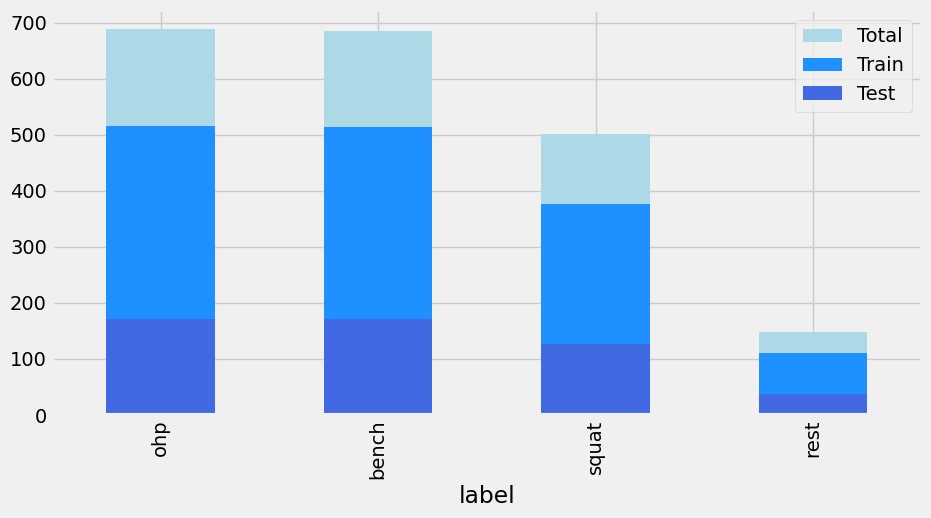

In [9]:
# Create a training and test set

df_train = df.drop(["participant", "category", "set"], axis=1)

X = df_train.drop("label", axis=1)
y = df_train["label"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

fig, ax = plt.subplots(figsize=(10,5))
df_train["label"].value_counts().plot(
    kind="bar", ax=ax, color="lightblue", label="Total"
)
y_train.value_counts().plot(kind="bar", ax=ax, color="dodgerblue", label="Train")
y_test.value_counts().plot(kind="bar", ax=ax, color="royalblue", label="Test")
plt.legend()
plt.show()

In [12]:
# Split feature subsets

basic_features = ["acc_x", "acc_y", "acc_z", "gyr_x", "gyr_y", "gyr_z"]
square_features = ["acc_r", "gyr_r"]
pca_features = ["pca_1", "pca_2", "pca_3"]
time_features = [f for f in df_train.columns if "_temp_" in f]
freq_features = [f for f in df_train.columns if (("_freq" in f) or ("_pse" in f))]
cluster_features = ["cluster"]

print ("Basic features:", len(basic_features))
print ("Square features:", len(square_features))
print ("PCA features:", len(pca_features))
print ("Time features:", len(time_features))
print ("Frequency features:", len(freq_features))
print ("Cluster features:", len(cluster_features))

feature_set_1 = list(set(basic_features))
feature_set_2 = list(set(basic_features + square_features + pca_features))
feature_set_3 = list(set(feature_set_2 + time_features))
feature_set_4 = list(set(feature_set_3 + freq_features + cluster_features))

Basic features: 6
Square features: 2
PCA features: 3
Time features: 16
Frequency features: 56
Cluster features: 1


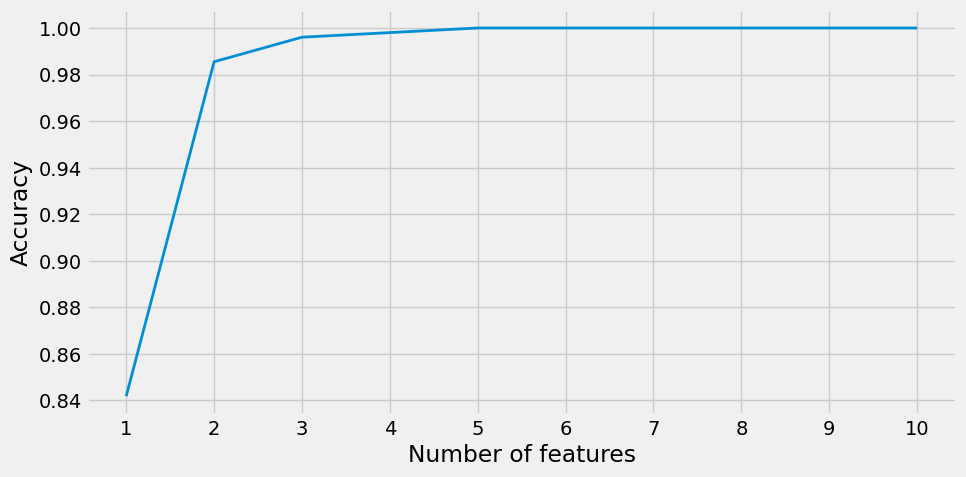

In [16]:
# Perform forward feature selection using simple decision tree

learner = ClassificationAlgorithms()

max_features = 10
selected_features, ordered_features, ordered_scores = learner.forward_selection(
    max_features, X_train, y_train
)

selected_features = [
    'acc_x_freq_0.0_Hz_ws_5',
    'duration',
    'acc_z_freq_0.0_Hz_ws_5',
    'gyr_z_temp_mean_ws_5',
    'acc_x',
    'gyr_r_freq_0.4_Hz_ws_5',
    'gyr_y_freq_weighted',
    'gyr_r_pse',
    'gyr_x_pse',
    'acc_r_freq_weighted'
]

plt.figure(figsize=(10, 5))
plt.plot(np.arange(1, max_features + 1, 1), ordered_scores)
plt.xlabel("Number of features")
plt.ylabel("Accuracy")
plt.xticks(np.arange(1, max_features + 1, 1))
plt.show()

In [19]:
# Grid search for best hyperparameters and model selection

possible_feature_sets = [
    feature_set_1,    
    feature_set_2,    
    feature_set_3,    
    feature_set_4,
    selected_features       
]

feature_names = [
    "Feature Set 1",
    "Feature Set 2",
    "Feature Set 3",
    "Feature Set 4",
    "Selected Features"
]

iterations = 1
score_df = pd.DataFrame()


for i, f in zip(range(len(possible_feature_sets)), feature_names):
    print("Feature set:", i)
    selected_train_X = X_train[possible_feature_sets[i]]
    selected_test_X = X_test[possible_feature_sets[i]]

    # First run non deterministic classifiers to average their score.
    performance_test_nn = 0
    performance_test_rf = 0

    for it in range(0, iterations):
        print("\tTraining neural network,", it)
        (
            class_train_y,
            class_test_y,
            class_train_prob_y,
            class_test_prob_y,
        ) = learner.feedforward_neural_network(
            selected_train_X,
            y_train,
            selected_test_X,
            gridsearch=False,
        )
        performance_test_nn += accuracy_score(y_test, class_test_y)

        print("\tTraining random forest,", it)
        (
            class_train_y,
            class_test_y,
            class_train_prob_y,
            class_test_prob_y,
        ) = learner.random_forest(
            selected_train_X, y_train, selected_test_X, gridsearch=True
        )
        performance_test_rf += accuracy_score(y_test, class_test_y)

    performance_test_nn = performance_test_nn / iterations
    performance_test_rf = performance_test_rf / iterations

    # And we run our deterministic classifiers:
    print("\tTraining KNN")
    (
        class_train_y,
        class_test_y,
        class_train_prob_y,
        class_test_prob_y,
    ) = learner.k_nearest_neighbor(
        selected_train_X, y_train, selected_test_X, gridsearch=True
    )
    performance_test_knn = accuracy_score(y_test, class_test_y)

    print("\tTraining decision tree")
    (
        class_train_y,
        class_test_y,
        class_train_prob_y,
        class_test_prob_y,
    ) = learner.decision_tree(
        selected_train_X, y_train, selected_test_X, gridsearch=True
    )
    performance_test_dt = accuracy_score(y_test, class_test_y)

    print("\tTraining naive bayes")
    (
        class_train_y,
        class_test_y,
        class_train_prob_y,
        class_test_prob_y,
    ) = learner.naive_bayes(selected_train_X, y_train, selected_test_X)

    performance_test_nb = accuracy_score(y_test, class_test_y)

    # Save results to dataframe
    models = ["NN", "RF", "KNN", "DT", "NB"]
    new_scores = pd.DataFrame(
        {
            "model": models,
            "feature_set": f,
            "accuracy": [
                performance_test_nn,
                performance_test_rf,
                performance_test_knn,
                performance_test_dt,
                performance_test_nb,
            ],
        }
    )
    score_df = pd.concat([score_df, new_scores])


Feature set: 0
	Training neural network, 0
	Training random forest, 0


/home/hamza-arain/Documents/code/HumanActiityTrack/.venv/lib/python3.10/site-packages/numpy/ma/core.py:2881: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


	Training KNN
	Training decision tree
	Training naive bayes
Feature set: 1
	Training neural network, 0
	Training random forest, 0
	Training KNN
	Training decision tree
	Training naive bayes
Feature set: 2
	Training neural network, 0
	Training random forest, 0
	Training KNN
	Training decision tree
	Training naive bayes
Feature set: 3
	Training neural network, 0
	Training random forest, 0
	Training KNN
	Training decision tree
	Training naive bayes
Feature set: 4
	Training neural network, 0
	Training random forest, 0
	Training KNN
	Training decision tree
	Training naive bayes


In [20]:
score_df

,model,feature_set,accuracy
0,NN,Feature Set 1,0.903162
1,RF,Feature Set 1,0.932806
2,KNN,Feature Set 1,0.699605
3,DT,Feature Set 1,0.903162
4,NB,Feature Set 1,0.861660
0,NN,Feature Set 2,0.907115
1,RF,Feature Set 2,0.948617
2,KNN,Feature Set 2,0.679842
3,DT,Feature Set 2,0.905138
4,NB,Feature Set 2,0.871542


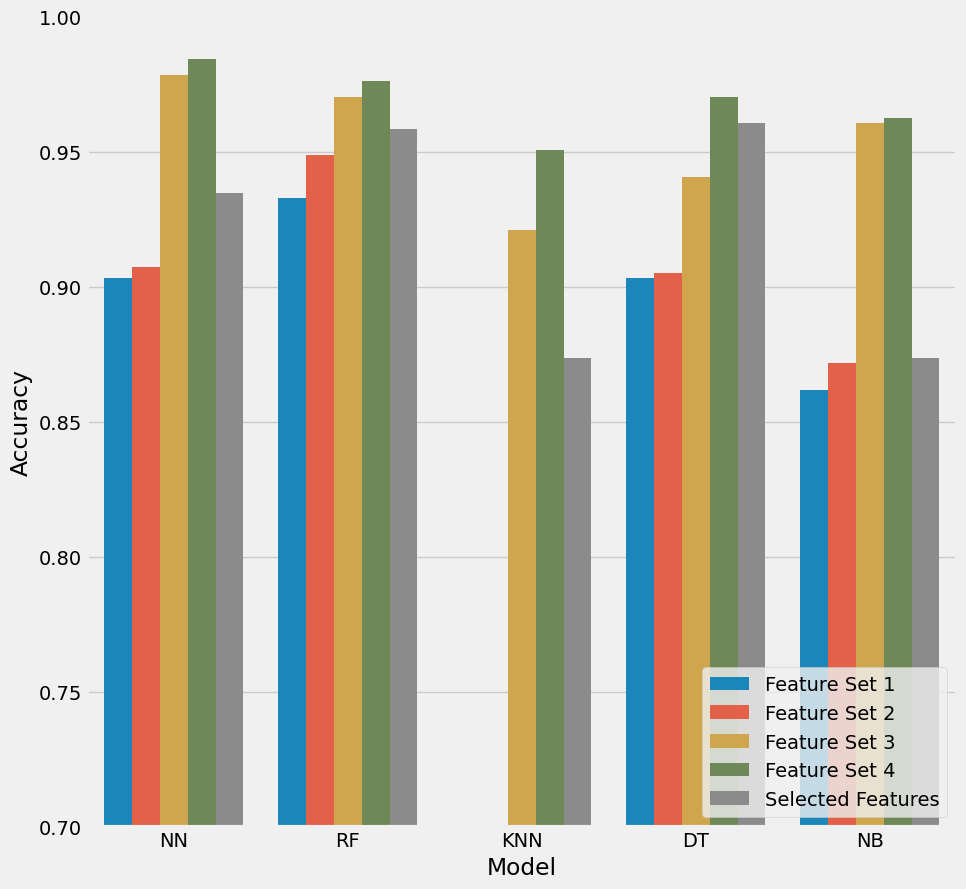

In [21]:
# Create a grouped bar plot to compare the results

score_df.sort_values(by="accuracy", ascending=False)

plt.figure(figsize=(10,10))
sns.barplot(x="model", y="accuracy", hue="feature_set", data=score_df)
plt.xlabel("Model")
plt.ylabel("Accuracy")
plt.ylim(0.7,1)
plt.legend(loc= "lower right")
plt.show()

In [23]:
# Select best model and evaluate results

(
    class_train_y,
    class_test_y,
    class_train_prob_y,
    class_test_prob_y
) = learner.random_forest(
    X_train[feature_set_4], y_train, X_test[feature_set_4], gridsearch=True
)

accuracy = accuracy_score(y_test, class_test_y)
classes = class_test_prob_y.columns
cm = confusion_matrix(y_test, class_test_y, labels=classes)


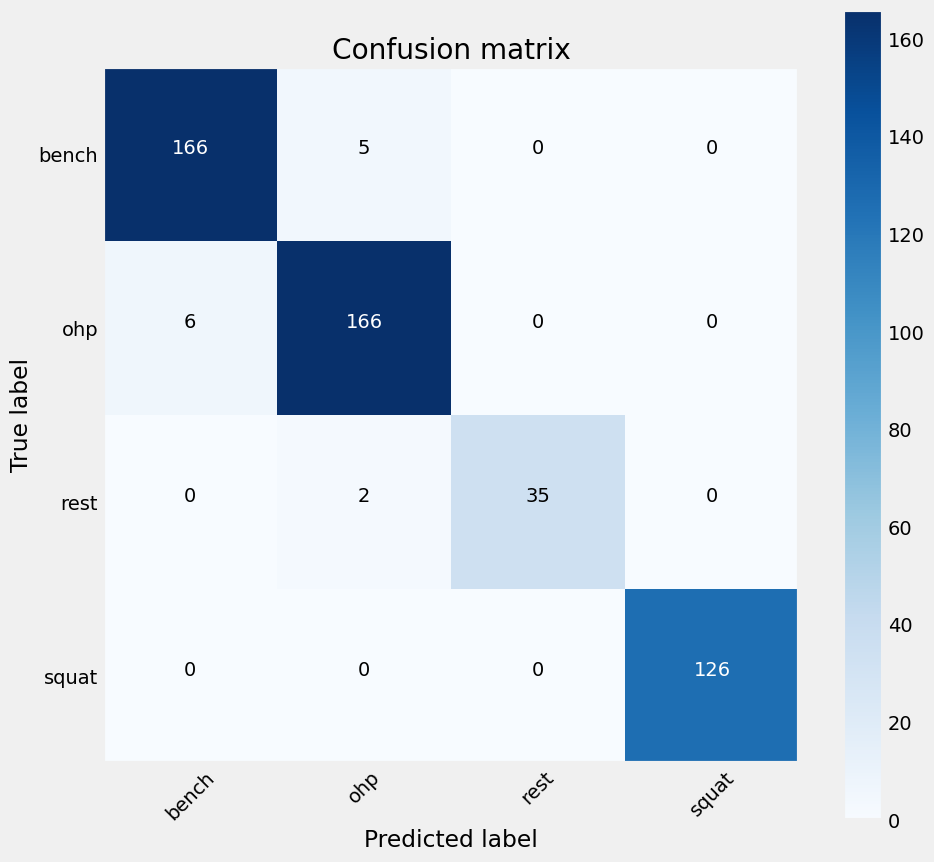

In [24]:
# Create Confusion Matrix for cm
plt.figure(figsize=(10, 10))
plt.imshow(cm, interpolation="nearest", cmap=plt.cm.Blues)
plt.title("Confusion matrix")
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)

thresh = cm.max() / 2.0
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(
        j,
        i,
        format(cm[i, j]),
        horizontalalignment="center",
        color="white" if cm[i, j] > thresh else "black",
    )
plt.ylabel("True label")
plt.xlabel("Predicted label")
plt.grid(False)
plt.show()

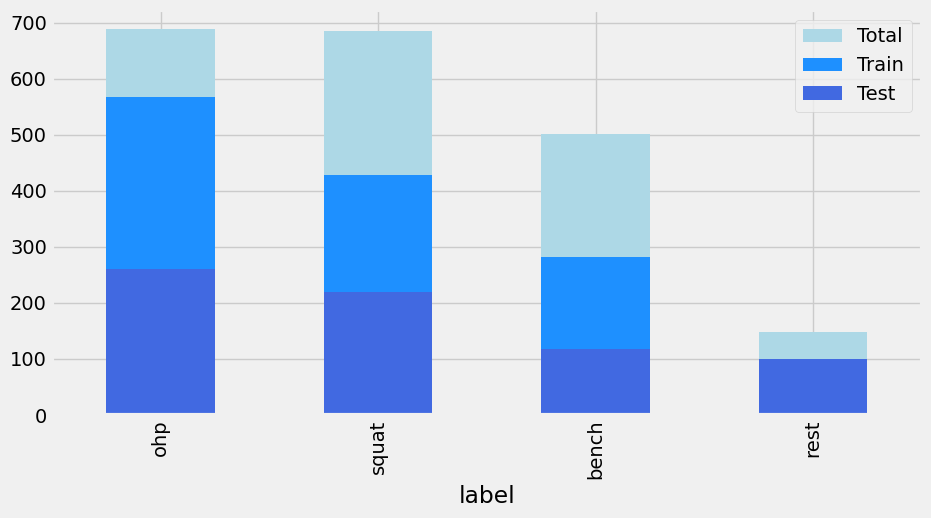

In [27]:
# Select train and test data based on participant

# Drop unnecessary columns
participant_df = df.drop(["set", "category"], axis=1)

# Separate train and test sets based on the "participant" column
X_train = participant_df[participant_df["participant"] != "A"].drop("label", axis=1)
y_train = participant_df[participant_df["participant"] != "A"]["label"]

X_test = participant_df[participant_df["participant"] == "A"].drop("label", axis=1)
y_test = participant_df[participant_df["participant"] == "A"]["label"]

# Drop "participant" column from both training and testing sets
X_train = X_train.drop(["participant"], axis=1)
X_test = X_test.drop(["participant"], axis=1)

# Plot label distributions for total, train, and test sets
fig, ax = plt.subplots(figsize=(10, 5))
df["label"].value_counts().plot(kind="bar", ax=ax, color="lightblue", label="Total")
y_train.value_counts().plot(kind="bar", ax=ax, color="dodgerblue", label="Train")
y_test.value_counts().plot(kind="bar", ax=ax, color="royalblue", label="Test")
plt.legend()
plt.show()


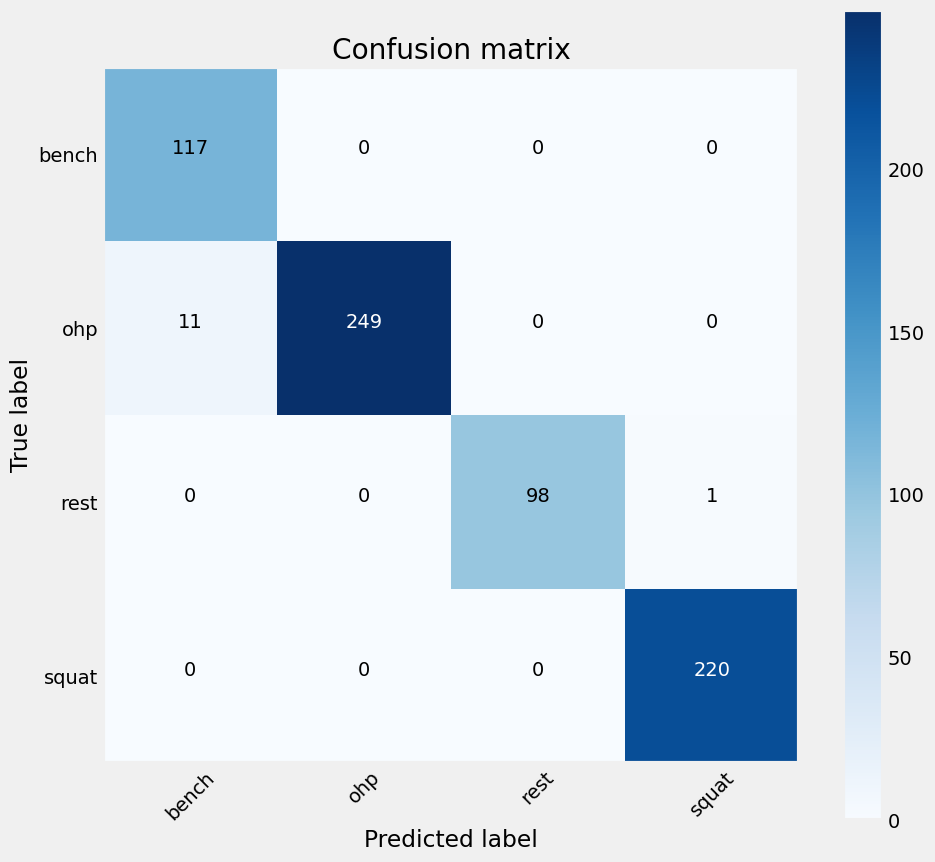

In [28]:
# Use best model again and evaluate results

(
    class_train_y,
    class_test_y,
    class_train_prob_y,
    class_test_prob_y
) = learner.random_forest(
    X_train[feature_set_4], y_train, X_test[feature_set_4], gridsearch=True
)

accuracy = accuracy_score(y_test, class_test_y)

classes = class_test_prob_y.columns
cm = confusion_matrix(y_test, class_test_y, labels=classes)

# Create Confusion Matrix for cm
plt.figure(figsize=(10, 10))
plt.imshow(cm, interpolation="nearest", cmap=plt.cm.Blues)
plt.title("Confusion matrix")
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)

thresh = cm.max() / 2.0
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(
        j,
        i,
        format(cm[i, j]),
        horizontalalignment="center",
        color="white" if cm[i, j] > thresh else "black",
    )
plt.ylabel("True label")
plt.xlabel("Predicted label")
plt.grid(False)
plt.show()


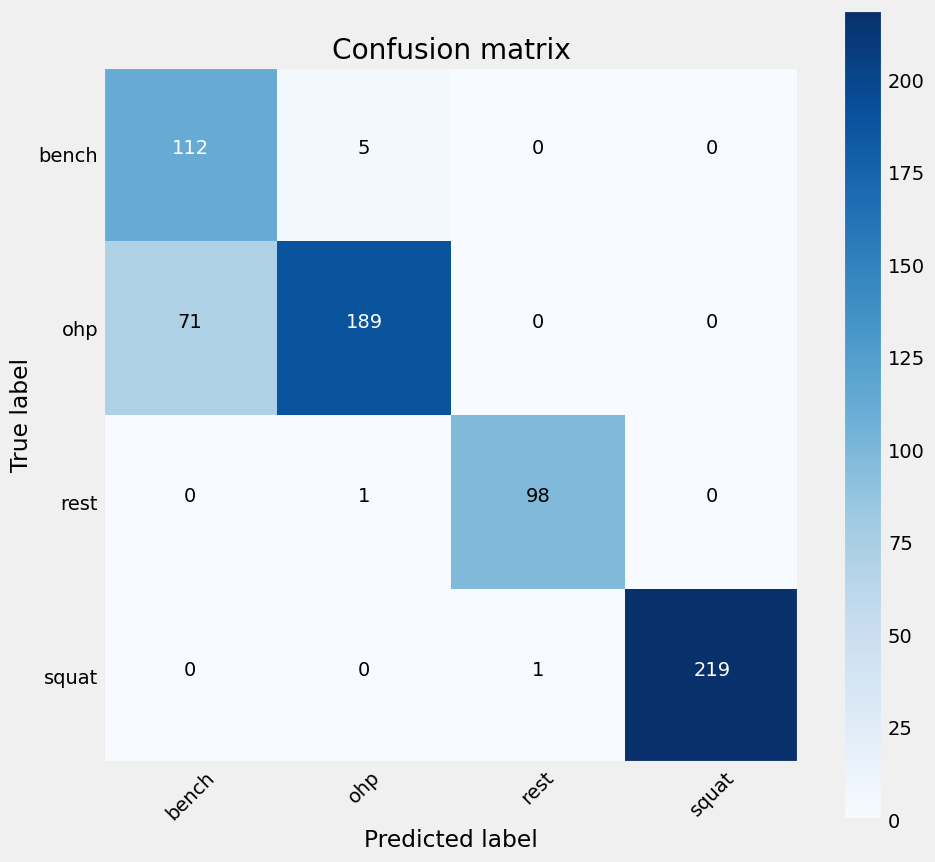

In [29]:
# Try a more complex model with the selected features

(
    class_train_y,
    class_test_y,
    class_train_prob_y,
    class_test_prob_y
) = learner.feedforward_neural_network(
    X_train[selected_features], y_train, X_test[selected_features], gridsearch=False
)

accuracy = accuracy_score(y_test, class_test_y)

classes = class_test_prob_y.columns
cm = confusion_matrix(y_test, class_test_y, labels=classes)

# Create Confusion Matrix for cm
plt.figure(figsize=(10, 10))
plt.imshow(cm, interpolation="nearest", cmap=plt.cm.Blues)
plt.title("Confusion matrix")
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)

thresh = cm.max() / 2.0
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(
        j,
        i,
        format(cm[i, j]),
        horizontalalignment="center",
        color="white" if cm[i, j] > thresh else "black",
    )
plt.ylabel("True label")
plt.xlabel("Predicted label")
plt.grid(False)
plt.show()